(50000, 28, 28) (50000,)


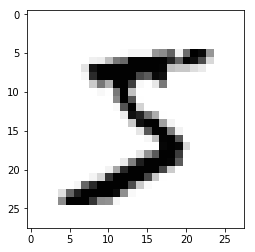

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [3]:
import tensorflow as tf
import numpy as np
import math
from tensorflow.python.framework import ops

In [4]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


In [5]:
print(y_train[0])

5


In [6]:
# Reshape the training, validate and test examples 
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

print(X_train_flatten.shape)
print(X_val_flatten.shape)
print(X_test_flatten.shape)

(784, 50000)
(784, 10000)
(784, 10000)


In [7]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    depth = tf.constant(C, name = "C")
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, depth, axis = 0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return one_hot

In [8]:
# encode y with one-hot
y_train_one_hot = one_hot_matrix(y_train, 10)
y_val_one_hot = one_hot_matrix(y_val, 10)
y_test_one_hot = one_hot_matrix(y_test, 10)

print(y_train_one_hot.shape)
print(y_val_one_hot.shape)
print(y_test_one_hot.shape)

(10, 50000)
(10, 10000)
(10, 10000)


In [9]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 28 * 28 = 784)
    n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    
    return X, Y

In [40]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [50, 784]
                        b1 : [50, 1]
                        W2 : [10, 50]
                        b2 : [10, 1]

    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours

    W1 = tf.get_variable("W1", [25,784], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [10, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [10,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> SIGMOID -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2"
                  the shapes are given in initialize_parameters

    Returns:
    Z2 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    ###                                                    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    
    return Z2

In [12]:
def compute_cost(Z2, Y):
    """
    Computes the cost
    
    Arguments:
    Z2 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z2
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- input target, of shape (10, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : ]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [41]:
def model(X_train, Y_train, X_val, Y_val, learning_rate = 0.001,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a two-layer tensorflow neural network: LINEAR->SIGMOID->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 784, number of training examples = 50000)
    Y_train -- training set, of shape (output size = 10, number of training examples = 50000)
    X_val -- validation set, of shape (input size = 784, number of validation examples = 10000)
    Y_val -- validation set, of shape (output size = 10, number of validation examples = 10000)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    val_costs = []                                    # # To keep track of the cost of validation
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)


    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z2 = forward_propagation(X, parameters)

    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z2, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
            
            val_cost = sess.run(cost, feed_dict={X: X_val, Y: Y_val})
            
            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f  ---  %f" % (epoch, epoch_cost, val_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                val_costs.append(val_cost)
            # Early stoping condition 
            #if np.absolute(costs[-1] - epoch_cost) < 1e-12:
            #    break
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost of training dataset')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        # plot the cost of validation
        plt.plot(np.squeeze(val_costs))
        plt.ylabel('cost of validation dataset')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Validation Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))
        
        return parameters

Cost after epoch 0: 0.475907  ---  0.254470
Cost after epoch 10: 0.109868  ---  0.139848
Cost after epoch 20: 0.075130  ---  0.134431
Cost after epoch 30: 0.056223  ---  0.147435
Cost after epoch 40: 0.042892  ---  0.155871
Cost after epoch 50: 0.032284  ---  0.171085
Cost after epoch 60: 0.024866  ---  0.193853
Cost after epoch 70: 0.020155  ---  0.213859
Cost after epoch 80: 0.015275  ---  0.223633
Cost after epoch 90: 0.011154  ---  0.251121


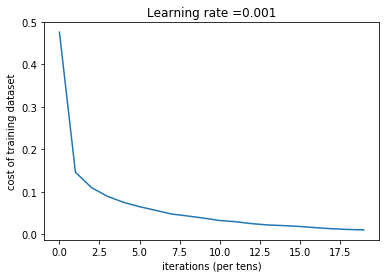

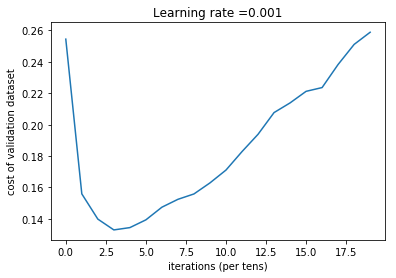

Parameters have been trained!
Train Accuracy: 0.9989
Validation Accuracy: 0.9556
CPU times: user 4min 10s, sys: 1min 7s, total: 5min 17s
Wall time: 3min 13s


In [42]:
%%time
parameters = model(X_train_flatten, y_train_one_hot, X_val_flatten, y_val_one_hot)

In [43]:
# Start the session to compute the tensorflow graph
with tf.Session() as sess:
    n_x = 784
    n_y = 10
    X, Y = create_placeholders(n_x, n_y)
    Z2 = forward_propagation(X, parameters)
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(Z2), tf.argmax(Y))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    print ("Test Accuracy:", accuracy.eval({X: X_test_flatten, Y: y_test_one_hot}))

Test Accuracy: 0.9578
